# Creating Model Age Spectra
 Example here is the model age spectra expect at an explored Curiosity site, telegraph peak 
 
 <nb>
    <nb>
- This notebook will create figure of the model mineralogy and the construct an age spectra from the diffusion kinetics that are found in the literature for each K-bearing phase with an assigned age given constraints from K-Ar measurement (Martin et al., (2017))

In [50]:
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("classic")
import seaborn as sns 
import pandas as pd

# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

In [51]:
# Murray Formation Mineralogy 
# Telegraph Peak 
plag = 27.1; san = 5.2; forsterite = 1.1; Pigeonite = 4.2; 
Orthopyroxene = 3.4; Magnetite = 8.2; Hematite = 1.1; 
Quartz = 0.9; Critobalite = 7.3; Jarosite = 1.5; 
Fluorapatite = 1.9; 
Opal_CT = 10.9; Amorphous = 27.2
import pandas as pd
df = pd.DataFrame({"Amorphous":[27.2],
                   "Plagioclase":[plag], 
                  "Sanidine": [san], 
                   "Jarosite": [1.5],
                  "Forsterote": [1.1], 
                  "Pigeonite": [4.2], 
                  "Orthopyroxene": [3.4], 
                  "Magnetite": [8.2], 
                  "Hematite": [1.1], 
                  "Quartz": [0.9], 
                  "Critobalite": [7.3],  
                  "Fluorapatite": [1.9], 
                  "Opal_CT":[10.9]})

In [52]:
# Cleaner Data Frame focussing on the minerals of interest
Other = 39
df2 = pd.DataFrame({"1 Jarosite": [1.5],
                    "2 Sanidine": [san],
                     "3 Plagioclase":[plag],
                    "Amorphous":[27.2],
                   "Non K-bearing phases":[39]})

# Model Mineralogy from XRD data 
* We highlight the K-bearing minerals and leave assign other to the non K-bearing phases

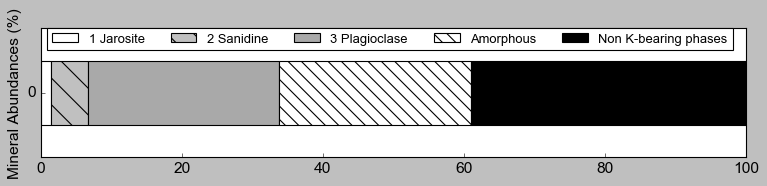

In [53]:
# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
ax = plt.figure(figsize = (10,2.1)).add_subplot(111)
df2.plot.barh(ax = ax, stacked = True, 
             color = ['w', 'silver', 'darkgrey', 'w', 
                     'k'])
plt.ylabel('Mineral Abundances (%)')

bars = ax.patches
patterns =('', '\\', '', '\\\\')
hatches = [p for p in patterns for i in range(len(df2))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::1], labels[::1], bbox_to_anchor=(0.99, 1.058),
 ncol=5, fontsize = 'small')

plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=1.5)
plt.savefig('Telegraph_Peak_Mineraogy.pdf')


# Fractional Release Equations 

In [54]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

# Age Equation

* Here we use theano to compute derivatives of the discretised fractional release equations

### Equation 1

In [55]:
import theano 
import theano.tensor as tt
from theano import pp 

In [56]:
def df1(ea, d0, a, temp, time): 
    x = tt.dvector('x') # Theano variable to differentiate w.r.t
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i 
    k = 6/(np.pi**(3/2))*np.sqrt(j*time)
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

def df2(ea, d0, a, temp, time): 
    x = tt.dvector('x')
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i
    k = (6/(np.pi**(3/2)))*np.sqrt(j*time) - (3/(np.pi**2))*j*time
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

def df3(ea, d0, a, temp, time): 
    x = tt.dvector('x')
    i = d0*np.exp(-ea/(R*x))
    j = ((np.pi**2)/(a**2)) * i 
    k =  1 - (6/np.pi**2)*np.exp(-j*time)
    w = k.sum() 
    gs = tt.grad(w, x)
    df = theano.function([x], gs)
    return df(temp)

In [57]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

## Martian Step Heating Schedule and Diffusion Kientics

* Time and temperature of each step 
* Currently assume all grains have same radii, which is a definite oversimplication and may require changing and further reading on typical grain radii for both the mineral phases and on the surface of Mars


In [58]:
temp = np.linspace(200, 1800, 50) + 273.15
time = 300*np.ones(len(temp))
R = 8.314e-3

# Grain size (same for all)

a = 0.01 #(cm)

# Jarosite (Kula & Baldwin, 2011)
eaj = 158.1552
d0j = np.exp(5.68 * 0.01**2) 

# Plagioclase (Jourdan and Eroglu,2017)
eap = 190
d0p = np.exp(4 * 0.01**2)

# Feldspar (Cassata and Renne, 2013) 
eaf = 220
d0f = np.exp(8.3) * 0.01**2



In [59]:
# Plotting Parameters Fonts

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# Jarosite 
* Cumulative Release
* Incremental Release

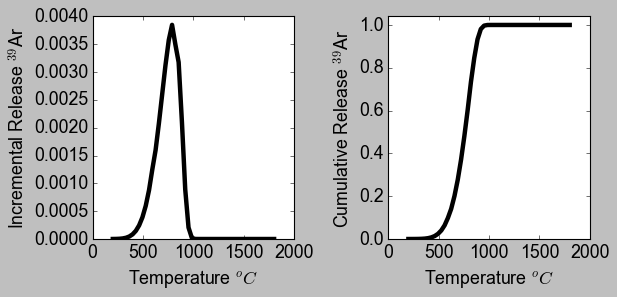

In [60]:
jj = fracrelx(eaj, d0j, a, temp, time).eval()
cc1 = Increment(eaj, d0j, a, temp, time).eval()


fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15, jj, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc1, lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')

ax[0].locator_params(axis='x', nbins=7)
ax[1].locator_params(axis='x', nbins=7)
plt.tight_layout()

# Plagioclase 

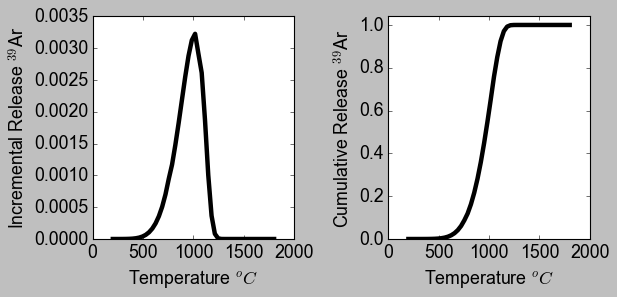

In [61]:
# Cumulative and Incremental Release

fp = fracrelx(eap, d0p, a, temp, time).eval()
cc2 = Increment(eap, d0p, a, temp, time).eval()

fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15,  fp, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc2[:len(temp)], lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')

ax[0].locator_params(axis='x', nbins=7)
ax[1].locator_params(axis='x', nbins=7)
plt.tight_layout()

# Feldspar

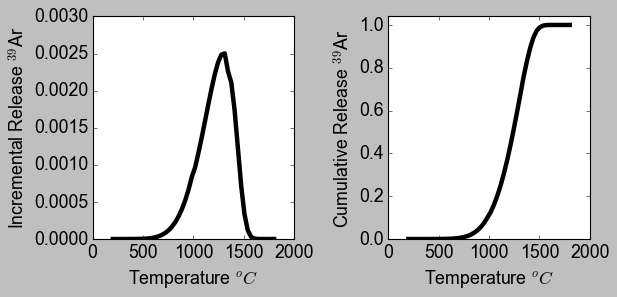

In [62]:
ff = fracrelx(eaf, d0f, a, temp, time).eval()
cc3 = Increment(eaf, d0f, a, temp, time).eval()

fig, ax = plt.subplots(1, 2, figsize = (8,4))
ax[1].plot(temp - 273.15,  ff, 
        lw = 4, color = 'k')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc3[:len(temp)], lw = 4, 
          color = 'k')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].set_xlabel('Temperature $^{o}C$')

ax[0].locator_params(axis='x', nbins=7)
ax[1].locator_params(axis='x', nbins=7)
plt.tight_layout()


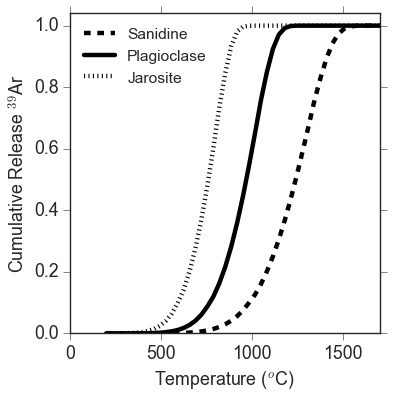

In [63]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(temp - 273.15,  ff[:len(temp)], 
        lw = 4, color = 'k', ls = '--', 
       label = 'Sanidine')

ax.plot(temp - 273.15,  fp[:len(temp)], label = 'Plagioclase',
        lw = 4, color = 'k')
ax.plot(temp - 273.15, jj, 
        lw = 4, color = 'k' , ls = ':', 
       label = 'Jarosite')

ax.set_ylabel('Cumulative Release $^{39}$Ar')
ax.set_xlabel('Temperature ($^{o}$C)')

ax.set_ylim(0, 1.04)
ax.set_xlim(0, 1700)

ax.locator_params(axis='y', nbins=8)
ax.locator_params(axis='x', nbins=8)
ax.legend(loc = 'best', fontsize = 14)
ax.locator_params(axis='x', nbins=7)

plt.savefig('Cumulative_Release_TelePeak_final.pdf')

# Combined plot of all fractional and Cumulative releases

In [64]:
# Cumulative Mars 

# Incremental 
yyz = 0.05*cc1 + 0.75*cc2 + 0.2*cc3
x1 = cc1/yyz
x2 = cc2/yyz
x3 = cc3/yyz
yy = 0.05*x1*cc1 + 0.75*x2*cc2 + 0.2*x3*cc3

y = np.cumsum(yy)
X = y/y.max()
X1 = 0.05*jj + 0.75*fp + 0.2*ff

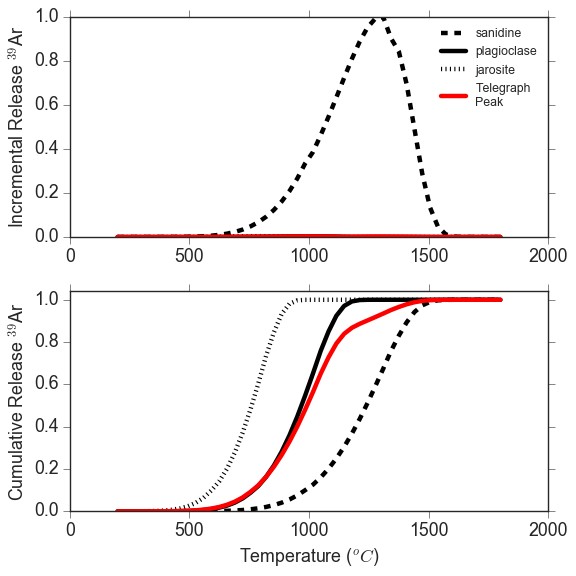

In [65]:
fig, ax = plt.subplots(2, 1, figsize = (7.48031, 7.48031))
ax[1].plot(temp - 273.15,  ff/ff.max(), 
        lw = 4, color = 'k', ls = '--')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc3/cc3.max(), lw = 4, 
          color = 'k', ls = '--', 
          label = 'sanidine')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')


ax[1].plot(temp - 273.15,  fp, 
        lw = 4, color = 'k')

ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc2, lw = 4, 
          color = 'k', 
          label = 'plagioclase')


ax[1].plot(temp - 273.15, jj, 
        lw = 4, color = 'k' , ls = ':')

ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, cc1, lw = 4, 
          color = 'k', 
          ls = ":", 
          label = 'jarosite')


# Telegraph Peak 
ax[1].plot(temp - 273.15,  X1, 
        lw = 4, color = 'r', ls = '-')
ax[0].plot(temp - 273.15, yy, lw = 4, 
          color = 'r', ls = '-', 
          label = 'Telegraph\nPeak')

ax[0].legend(loc = 'best', 
            fontsize = 'x-small')

ax[0].set_xlim(0, 2000)
ax[1].set_xlim(0, 2000)
plt.tight_layout()
plt.savefig('TelegraphPeak_relcurves_2.pdf')

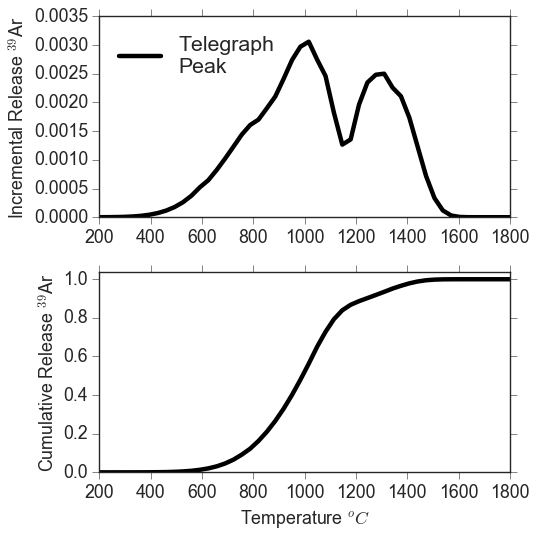

In [66]:
fig, ax = plt.subplots(2, 1, figsize = (7, 7))

ax[1].plot(temp - 273.15,  X1, 
        lw = 4, color = 'k', ls = '-')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[1].set_xlabel('Temperature $^{o}C$')
ax[1].set_ylim(0, 1.04)

ax[0].plot(temp - 273.15, yy, lw = 4, 
          color = 'k', ls = '-', 
          label = 'Telegraph\nPeak')
ax[0].set_ylabel('Incremental Release $^{39}$Ar')
ax[0].legend(loc = 2)
plt.tight_layout()

# Age Spectra
* Forming the age spectra 
* Multi-component Age Spectra equation is given by the follow

$$ Age_{m} = \frac{\sum_{i = 1}^{k}\phi_{(i)} Age_{(i)} \frac{\delta F_{(i)}}{\delta T}}{\sum_{i = 1}^{k}\phi_{(i)} \frac{\delta F_{(i)}}{\delta T}}$$

* Age$_{m}$ is the observed Age spectra data
* $\phi$ - Volume fraction of each domain/sphere of each phase
* $\frac{\delta F_{(i)}}{\delta T}$ - Derivative of the cumulative release
* Age$_{i}$ - Age of each component

## Telegraph peak age spectra

In [67]:
temp = np.linspace(200, 1700, 30) + 273.15
time = 1200*np.ones(len(temp))
R = 8.314e-3

# Grain size (same for all)

a = 0.01 #(cm)

# Jarosite (Kula & Baldwin, 2011)
eaj = 158.1552
d0j = np.exp(5.68 * 0.01**2) 

# Plagioclase (Jourdan and Eroglu,2017)
eap = 190
d0p = np.exp(4 * 0.01**2)

# Feldspar (Cassata and Renne, 2013) 
eaf = 220
d0f = np.exp(8.3) * 0.01**2

a1 = 2.1e9
a2 = 4.3e9
a3 = 4.1e9


c1 = Increment(eaj, d0j, a, temp, time).eval()
c2 = Increment(eap, d0p, a, temp, time).eval()
c3 = Increment(eaf, d0f, a, temp, time).eval()

y = 0.05*c1 + 0.75*c2 + 0.2*c3


ff = fracrelx(eaf, d0f, a, temp, time).eval()
jj = fracrelx(eaj, d0j, a, temp, time).eval()
fp = fracrelx(eap, d0p, a, temp, time).eval()


X = 0.05*jj + 0.75*fp + 0.2*ff

In [68]:
def age_spectra(samples): 
    age = []
    frel = []
    for i in range(samples): 
        age1 = np.random.normal(2100, 125)
        age2 = np.random.normal(4100, 25.0)
        age3 = np.random.normal(4300, 100)
        
        # Jarosite (Kula & Baldwin, 2011)
        eaj = 158.1552
        d0j = 5.68 

        # Plagioclase (Jourdan and Eroglu,2017)
        eap = 190
        d0p = 0.1

        # Feldspar (Cassata and Renne, 2013) 
        eaf = 220
        d0f = np.exp(8.3) * 0.01**2

        a = 0.01
        
        c1 = Increment(eaj, d0j, a, temp, time).eval()
        c2 = Increment(eap, d0p, a, temp, time).eval()
        c3 = Increment(eaf, d0f, a, temp, time).eval()
        
        Q = 0.05*c1 + 0.75*c2 + 0.2*c3
        
        # Telegraph peak Age Spectra
        age_m = 0.05*(c1*age1)/Q + 0.75*(c2*age3)/Q + 0.2*(c3*age2)/Q
        age_m = age_m + np.random.uniform(-50, 50, len(temp))
        age.append(age_m)
        
        f1 = fracrelx(eaj, d0j, a, temp, time).eval()
        f2 = fracrelx(eap, d0p, a, temp, time).eval()
        f3 = fracrelx(eaf, d0f, a, temp, time).eval() 
        
        
        Z = 0.05*f1 + 0.75*f2 + 0.2*f3
        frel.append(Z)
        
    return np.array(age), np.array(frel)


In [69]:
age_m, frel = age_spectra(50)

low_data, high_data = np.percentile(age_m[-500:],
                                    [2.5, 97.5], 
                                    axis = 0)

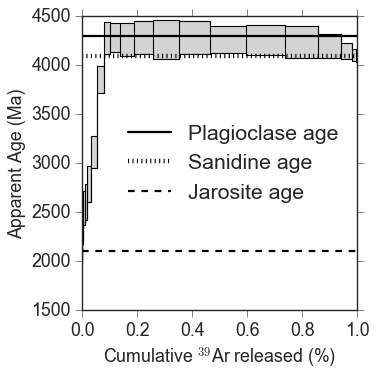

In [70]:
sns.set_style('ticks')
plt.figure(figsize = (5, 5))
plt.fill_between(frel.mean(axis = 0), low_data, high_data,
                step = 'pre', color ='lightgrey', 
                 alpha = 1, edgecolor= 'k') 
plt.axhline(4300,lw = 2, color = 'k', 
           ls = '-', 
           label = 'Plagioclase age')
plt.axhline(4100,lw = 4, color = 'k', 
           ls = ':', 
           label = 'Sanidine age')
plt.axhline(2100, lw = 2, color = 'k', 
           ls = '--', 
           label = 'Jarosite age')

for i in range(len(low_data)): 
    plt.vlines(frel.mean(axis = 0)[i], 
              low_data[i], high_data[i], lw = 1, 
              color = 'k')

plt.ylabel('Apparent Age (Ma)')
plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.legend(loc = 'best') 
plt.tight_layout()
plt.savefig('Tpeak_age_spec2.pdf')


# Sum of Squares Likelihood

In [71]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

class Sum_of_Squares(pm.distributions.Continuous):
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
        
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

# Age Spectra and Mineralogy 

In [72]:
# Age Spectra Model 
data = age_m.mean(axis = 0)
err = (data - low_data)
fractional = frel.mean(axis = 0)
data2 = frel.mean(axis = 0)

In [73]:
import theano.tensor as tt
from theano import shared
age_err = shared(err)

In [74]:
data = age_m;

In [75]:
data_age = age_m.mean(axis = 0)

In [95]:
data_age
N = data_age.shape[0]

In [96]:
TelePeak = pm.Model() 
with TelePeak: 
    
    """
    Mixing Fraction prior
    Dirichlet priors shape equal to 
    the number of components
    """ 
    phi = pm.Dirichlet('phi',
                       a = np.array([1,1,1]),
                       shape = 3)

    """
    Activation Energy
    and Frequency Factor
    """
    ea1 = pm.Normal('ea1', mu = 158,
                    sd = 13)
    ea2 = pm.Normal('ea2', mu = 190,
                    sd = 10)
    ea3 = pm.Normal('ea3', mu = 225,
                    sd = 8)
    
    d01 = pm.Normal('d01', mu = 5.6,
                       sd = 0.6)
    
    
    lnd02 = pm.Normal('lnd02', mu = 1.1,
                       sd = 0.1)
    
    d02 = pm.Deterministic('d02', np.exp(lnd02))
    
    
    lnd03 = pm.Normal('lnd03', mu = 8.3,
                       sd = 1)
    
    d03 = pm.Deterministic('d03',
                           np.exp(lnd03) * 0.01**2)
    

    """
    Effective Diffusion lengthscale
    ~ grain radii
    """
    a1 = pm.Normal('a1', mu = 0.01, sd = 0.0005)
    
    a2 = pm.Normal('a2', mu = 0.01, sd = 0.0005)
    
    a3 = pm.Normal('a3', mu = 0.01, sd = 0.0005)

In [97]:
with TelePeak: 
    """
    Age Priors 
    Uniform between 0 - 4.6 Ga
    """
    age1 = pm.Uniform('age1',  lower = 0.0,
                             upper = 4600)
    
    age2 = pm.Uniform('age2',  lower = 0.0,
                             upper = 4600)
    
    age3 = pm.Uniform('age3',  lower = 0.0,
                             upper = 4600)

In [98]:
with TelePeak: 
    """
    Age Model 
    """
    X = Increment(ea1, d01,
                  a1, temp, time)
    Y = Increment(ea2, d02,
                  a2, temp, time)
    Z = Increment(ea3, d03,
                  a3, temp, time)
    
    # Assign Mixing Fractions to each component
    m1 = phi[0]
    m2 = phi[1]
    m3 = phi[2]
    
    """
    
    Multiple Component 40Ar/39Ar age spectra plot
    
    """
    WW = (m1*X + m2*Y + m3*Z)
    
    mu1 = (m1*X)/(WW); mu2 = (m2*Y)/(WW); mu3 = (m3*Z)/(WW)
    
    # Age spectra model
    model = mu1*age1 + mu2*age2 + mu3*age3



In [99]:
with TelePeak:
    """
    Cumulative Release Model
    """
    A = fracrelx(ea1, d01,
                 a1, temp, time)
    B = fracrelx(ea2, d02,
                 a2, temp, time)
    C = fracrelx(ea3, d03,
                 a3, temp, time)
    # Fractional Release Model 
    model2 = m1*A + m2*B + m3*C
    
    for i in range(len(temp)- 1):
        model2_con = pm.Potential(f'model2_con{i}', 
                                 tt.switch(model2 < 0, 
                                          -np.inf, 0))
    
    # Fractional Release Model error
    f_err = pm.HalfNormal('f_err', 
                         sd = 0.1, 
                         shape = N)

In [100]:
with TelePeak:
    age_model = pm.Deterministic('age_model', model)
    frel_model = pm.Deterministic('frel_model', model2)

In [101]:
with TelePeak: 
    """
    Cumulative release and 
    age spectra Likelihoods
    """
    obs = pm.Normal('obs', model, err, 
                         observed = data_age) 
    
    obs2 = pm.Normal('obs2', mu = model2, sd = f_err, 
                    observed = data2)

# Check Test Point

In [102]:
TelePeak.check_test_point()

a1                          6.68
a2                          6.68
a3                          6.68
age1_interval__            -1.39
age2_interval__            -1.39
age3_interval__            -1.39
age_model_error_log__     -23.10
d01                        -0.41
ea1                        -3.48
ea2                        -3.22
ea3                        -3.00
f_err_log__               -23.10
lnd02                       1.38
lnd03                      -0.92
obs                     -5210.21
obs2                      -31.55
phi_stickbreaking__        -2.60
Name: Log-probability of test_point, dtype: float64

In [103]:
SAMPLES = 100000
BURN = 200000
SEED = np.random.seed(1234)

with TelePeak: 
    step1 = pm.Metropolis([f_err, age_model_error, 
                          age1, age2, age3, 
                          a1, a2, a3,d01, 
                          d02, d03,ea1, ea2, 
                          ea3, phi])

    trace = pm.sample(SAMPLES,
                      tune = BURN,
                      step = [step1], 
                     random_seed = SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [phi]
>Metropolis: [ea3]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [lnd03]
>Metropolis: [lnd02]
>Metropolis: [d01]
>Metropolis: [a3]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [age3]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [age_model_error]
>Metropolis: [f_err]
Sampling 2 chains: 100%|██████████| 600000/600000 [1:23:43<00:00, 119.44draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


In [105]:
with TelePeak: 
    ppc = pm.sample_ppc(trace[-10000:], 5000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 5000/5000 [01:13<00:00, 67.69it/s]


In [106]:
w = ppc['obs'].mean(axis = 0)
w2 = ppc['obs2'].mean(axis = 0)

f_low, f_high = np.percentile(ppc['obs2'], [10, 90], axis = 0)
age_mod_low, age_mod_high = np.percentile(ppc['obs'], [2.5, 97.5], axis = 0)



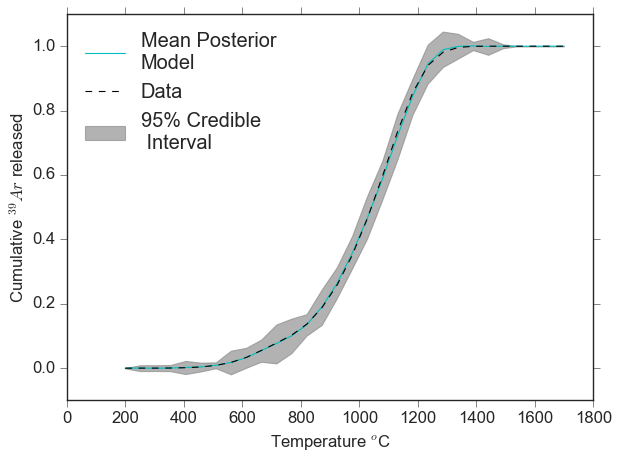

In [107]:
sns.set_style('ticks')
plt.figure()
plt.plot(temp - 273.15, w2, 
        label = 'Mean Posterior \nModel', color = 'c', alpha = 1)
plt.plot(temp -273.15, data2, label = 'Data', color= 'k', ls= '--')
plt.fill_between(temp - 274.15, f_low, f_high, 
                color = 'grey', alpha =  0.6, 
                label = '95% Credible \n Interval')
plt.ylim(-0.1, 1.1)
plt.xlabel('Temperature $^{o}$C')
plt.ylabel('Cumulative $^{39}Ar$ released')
plt.legend(loc = 2)
plt.tight_layout()
plt.savefig('TelePeak_model_frel.pdf')

(<matplotlib.axes._subplots.AxesSubplot at 0x1c918089b0>, GridSpec(2, 2))

<Figure size 240x240 with 0 Axes>

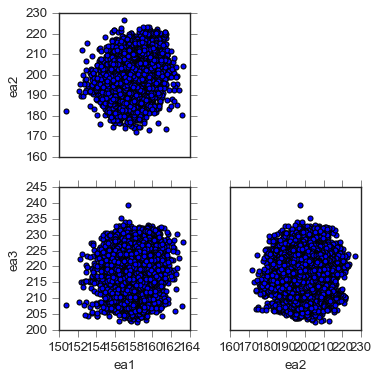

In [108]:
sns.set_style('ticks')
plt.figure(figsize = (3,3))
pm.pairplot(trace[-SAMPLES::20], 
           varnames = ['ea1', 'ea2', 'ea3'], 
           figsize = (5,5))

In [109]:
# Plotting Parameters
data2 
data 
age_low_plot = np.insert(age_mod_low, 0, age_mod_low[0])
age_high_plot = np.insert(age_mod_high, 0, age_mod_high[0])
f_mod_plot = np.insert(w2, 0, 0)

model_plot = np.insert(w, 0, w[0])

low_data_plot = np.insert(low_data, 0, low_data[0])
high_data_plot = np.insert(high_data, 0, high_data[0])

data_plot = np.insert(data, 0, data[0])
f_plot = np.insert(data2, 0, 0)

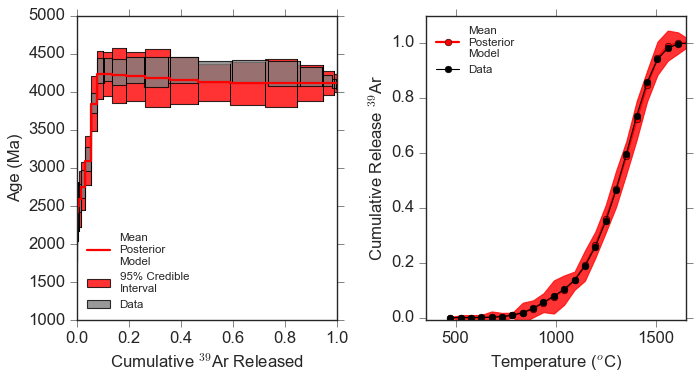

In [110]:
fig, ax = plt.subplots(1, 2, figsize = (9, 5))
ww = data2
ax[0].fill_between(f_mod_plot, age_low_plot, 
                  age_high_plot, 
                  step = 'pre',  
                  alpha = 0.8, 
                  facecolor = 'r', 
                  label = '95% Credible\nInterval', 
                  edgecolor = 'k')

ax[0].plot(f_mod_plot, model_plot, 'r-', 
          lw = 2, 
          label = 'Mean\nPosterior\nModel', 
          drawstyle = 'steps')


ax[0].fill_between(f_plot, low_data_plot, high_data_plot, 
                   step = 'pre', alpha = 0.8, facecolor = 'grey',
          edgecolor = 'k', 
                  label = 'Data')

for i in range(len(data)): 
    ax[0].vlines(f_mod_plot, age_low_plot, 
                  age_high_plot, color = 'k', lw= 0.7)

for i in range(len(data)): 
    ax[0].vlines(f_plot, low_data_plot, high_data_plot, 
                 color = 'k', lw= 0.7)

ax[1].fill_between(temp, f_low, f_high, 
                  color = 'r', alpha = 0.8)

ax[1].plot(temp, w2, '-or', 
          lw = 2, label = 'Mean\nPosterior\nModel')
ax[1].plot(temp, data2, '-ok', 
          label = 'Data')

ax[0].set_xlim(0, 1)
ax[1].set_ylim(-0.01, 1.1)
ax[0].set_ylim(1000, 5000)
ax[1].set_xlim(350, 1650)
ax[1].locator_params(axis='x', nbins=7)

ax[0].set_xlabel('Cumulative $^{39}$Ar Released')
ax[0].set_ylabel('Age (Ma)')

ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[1].set_ylabel('Cumulative Release $^{39}$Ar')
ax[0].legend(fontsize = 'x-small', loc = 'best')
ax[1].legend(fontsize = 'x-small', loc = 2)
plt.tight_layout()

# DataFrame for plotting 


In [111]:
df = pd.DataFrame({"temp": temp, 
                  "frac_rel_model": w2, 
                  "f_low": f_low, 
                  "f_high": f_high, 
                  "f_data": data2, 
                  "age_data_low": low_data, 
                  "age_data_high": high_data, 
                  "age_data": data.mean(axis = 0), 
                  "mod_low": age_mod_low, 
                  "mod_high": age_mod_high, 
                  "age_model": w})


df.to_csv("/Users/jackcarter/Documents/Data_Mixtures/telepeak_post.csv")

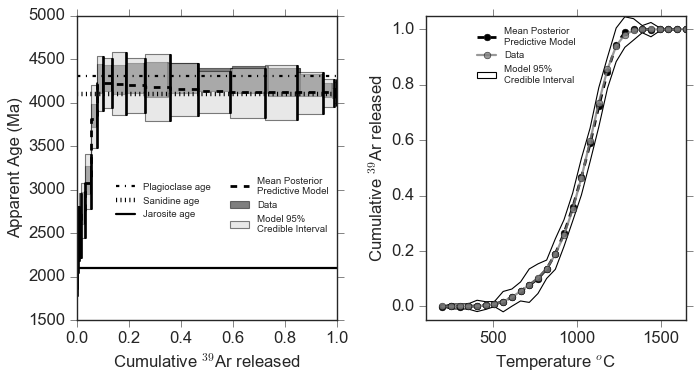

In [115]:

sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
fig,ax = plt.subplots(1,2, figsize = (9, 5))
# Fractional Release
ax[1].plot(temp - 273.15, w2, '--o', color = 'k',
           lw = 2.5, alpha = 1,
          label = 'Mean Posterior\nPredictive Model')
ax[1].plot(temp -273.15, data2, '-o', label = 'Data', color= 'grey',lw = 2,
          alpha = 0.8)
ax[1].fill_between(temp - 273.15, f_low, f_high, 
                facecolor = 'None',
                   alpha =  1, edgecolor = 'k',
                label = 'Model 95%\nCredible Interval')
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xlabel('Temperature $^{o}$C')
ax[1].set_ylabel('Cumulative $^{39}$Ar released')

ax[1].plot(data2, w, lw = 2.5, drawstyle = 'steps', color = 'k')
ax[1].fill_between(data2, f_low, f_high, facecolor = 'None', alpha = 1,
                   edgecolor = 'k',
                 step = 'pre')

ax[1].set_xlim(temp.min() - 273.15, temp.max() - 273.15)

#Age Spectra
ax[0].fill_between(data2, low_data, high_data,
                step = 'pre', color ='k', 
                 alpha = 0.5, edgecolor= 'k', label = 'Data') 
ax[0].axhline(4300,lw = 2, color = 'k', 
           ls = 'dashdot', 
           label = 'Plagioclase age')
ax[0].axhline(4100,lw = 4, color = 'k', 
           ls = ':', 
           label = 'Sanidine age')
ax[0].axhline(2100, lw = 2, color = 'k', 
           ls = '-', 
           label = 'Jarosite age')

ax[0].plot(w2, trace['age_model'].mean(axis = 0), lw = 2.5, 
           drawstyle = 'steps', color = 'k', 
        label = 'Mean Posterior\nPredictive Model', 
          ls = '--')
ax[0].fill_between(w2, age_mod_low, age_mod_high,
                   color = 'lightgrey', alpha = 0.5,
                   edgecolor = 'k',
                 step = 'pre',
                label = 'Model 95%\nCredible Interval')


for i in range(len(age_mod_low)): 
    ax[0].vlines(w2, 
              age_mod_low, age_mod_high, lw = 0.-1, 
              color = 'k')
    
    
for i in range(len(age_mod_low)): 
    ax[0].vlines(frel.mean(axis = 0), 
              low_data,high_data,
              lw = 0.01
                 , 
              color = 'k')

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released')
ax[0].legend(bbox_to_anchor = (1, 0.5), 
            fontsize = 'xx-small', 
            ncol = 2) 
ax[1].legend(bbox_to_anchor = (0.61, 0.99), 
            fontsize = 'xx-small')



ax[1].locator_params(axis='x', nbins= 8)
ax[0].locator_params(axis='x', nbins=5)
ax[1].set_xlim(100, 1650)

ax[0].set_xlim(0, 1)
ax[0].set_ylim(1500, 5000)
ax[1].set_ylim(-0.05,1.05)
plt.tight_layout()
plt.savefig('TelePeak_latest_final.pdf')

# AGES

In [113]:
print(trace['age1'].mean()/1e3, trace['age1'].std()/1e3)
print(trace['age2'].mean()/1e3, trace['age2'].std()/1e3)
print(trace['age3'].mean()/1e3, trace['age3'].std()/1e3)

2.20705529454377 0.0853671601013712
4.423701887709749 0.1388426074900294
4.116604325049645 0.01912756209715718


In [116]:
trace['phi'].mean(axis = 0)

array([0.0531057 , 0.12483957, 0.82205473])

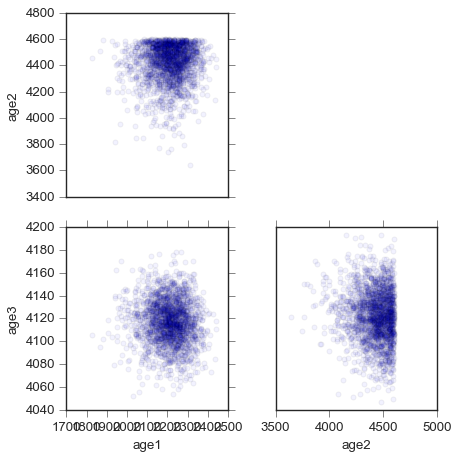

In [119]:
pm.pairplot(trace[-SAMPLES::100
                 ], varnames = ['age1', 'age2', 'age3'], 
           figsize = (6,6), 
           alpha = 0.05)

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)

In [120]:
# DataFrames for plotting 
df = pd.DataFrame({"frel": w2, 
                  "low_frel":f_low, 
                  "high_frel":f_high, 
                  "age_model":w,
                  "low_age_m":age_mod_low, 
                  "high_age_m":age_mod_high})
df.to_csv("TelePeak_model.csv")

In [121]:
df2 = pm.trace_to_dataframe(trace)
df2.to_csv('TelePeak_trace.csv')

In [122]:
import matplotlib.tri as tri
from scipy import stats as st

from functools import reduce
_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
        for i in range(3)]


def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    _, axes = plt.subplots(1,2,figsize=(9, 6))
    if barycentric is True:
        X = X.dot(_corners)
        
    sns.kdeplot(X[:, 0], X[:,1], shade=True, shade_lowest=False, 
                ax=axes[0])
    axes[1].plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs)
    for ax in axes:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        ax.axis('equal')
        ax.axis('on')
        if border is True:
            ax.triplot(_triangle, linewidth=1)

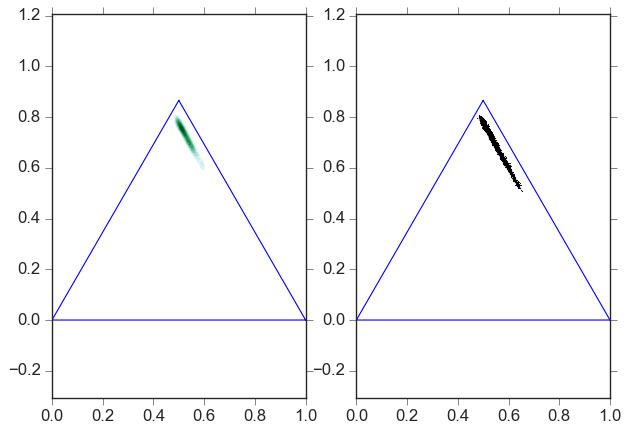

In [123]:
"""
A 2-simplex for 3 component data

"""

plot_points(trace['phi'][-SAMPLES::10])

# Posterior Data Frames

* dfp - dataframe of desired model parameters 
    - Activation energy 
    - Freqency Factor 
    - Ages 
    
* dfp is the dataframe to use for plotting the pairgrid

In [124]:
dfp = pd.DataFrame({"age1":df2['age1'].values/1e3, 
                   "age2": df2['age2'].values/1e3, 
                    "age3":df2['age3'].values/1e3,
                    "ea1":df2['ea1'].values,
                    "ea2":df2['ea2'].values,
                    "ea3":df2['ea3'].values, 
                    "d01":np.log(df2['d01'].values), 
                    "d02":np.log(df2['d02'].values), 
                    "d03":np.log(df2['d03'].values)
                   })

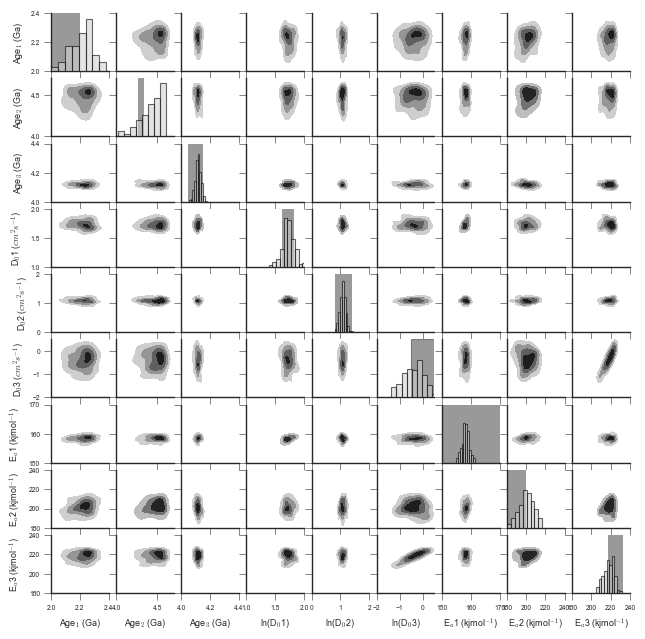

In [127]:
import seaborn as sns
sns.set_style('ticks')
font = {"family":"Arial", 
       "weight": "normal",
     "size": 8}


plt.rc("font", **font)

g = sns.PairGrid(dfp[-SAMPLES::400])
g = g.map_diag(plt.hist, facecolor = 'lightgrey', edgecolor = 'k', 
              alpha = 0.6)
g.fig.set_size_inches(7.5,7.5)
g = g.map_offdiag(sns.kdeplot, cmap = 'Greys', 
                 n_levels = 4,
                 shade = True,
                 shade_lowest = False)


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ga)')
g.axes[1,0].set_ylabel('Age$_2$ (Ga)')
g.axes[2,0].set_ylabel('Age$_3$ (Ga)')
g.axes[3,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,0].set_ylabel('D$_0$3 ($cm^{2}s^{-1}$)')
g.axes[6,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[7,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')
g.axes[8,0].set_ylabel('E$_a$3 (kjmol$^{-1}$)')




# X_AXIS LABELS

g.axes[8,0].set_xlabel('Age$_1$ (Ga)')
g.axes[8,1].set_xlabel('Age$_2$ (Ga)')
g.axes[8,2].set_xlabel('Age$_3$ (Ga)')
g.axes[8,3].set_xlabel('ln(D$_0$1) ')
g.axes[8,4].set_xlabel('ln(D$_0$2)') 
g.axes[8,5].set_xlabel('ln(D$_0$3)')
g.axes[8,6].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[8,7].set_xlabel('E$_a$2 (kjmol$^{-1}$)')
g.axes[8,8].set_xlabel('E$_a$3 (kjmol$^{-1}$)')

g.axes[0,0].axvspan(2,2.2, lw = 0, color = 'k', 
                    alpha = 0.4)
g.axes[1,1].axvspan(4.3 - 0.035,4.3 + 0.035, lw = 0, color = 'k', 
                    alpha = 0.4)
g.axes[2,2].axvspan(4.050, 4.150, lw = 0, color = 'k', 
                   alpha = 0.4)
g.axes[5,5].axvspan(-0.5,2.5, 
                    color = 'k', ymax = 1, 
              alpha = 0.4)
g.axes[3,3].axvspan(np.log(5),np.log(6.2),ymax = 1, lw = 0, color = 'k', 
                   alpha = 0.4)
g.axes[4,4].axvspan(0.8, 1.4 ,ymax = 1, lw = 0, color = 'k', 
                   alpha = 0.4)
g.axes[6,6].axvspan(158 - 13, 158 + 13, ymax = 1, color = 'k',
                   alpha = 0.4, lw = 0)
g.axes[7,7].axvspan(180, 200, ymax = 1, color = 'k', 
                   lw = 0, alpha = 0.4)
g.axes[8,8].axvspan(225 - 8, 225 + 8, ymax = 1, color = 'k', 
                   alpha = 0.4, lw = 0)



# Axis limits
 
g.axes[0,0].set_ylim(2.000, 2.400)
g.axes[0,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,0].set_xlim(2.000, 2.400)
g.axes[8,0].locator_params(axis = 'x', nbins = 3)


g.axes[1,0].set_ylim(4.00,4.700)
g.axes[1,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,1].set_xlim(4.00,4.700)
g.axes[8,1].locator_params(axis = 'x', nbins = 3)



g.axes[2,0].set_ylim(4.0,4.4)
g.axes[2,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,2].set_xlim(4.0,4.4)
g.axes[8,2].locator_params(axis = 'x', nbins = 3)


g.axes[3,0].set_ylim(1,2)
g.axes[3,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,3].set_xlim(1,2)
g.axes[8,3].locator_params(axis = 'x', nbins = 3)



g.axes[4,0].set_ylim(0,2)
g.axes[4,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,4].set_xlim(0,2)
g.axes[8,4].locator_params(axis = 'x', nbins = 3)


g.axes[5,0].set_ylim(-2,0.5)
g.axes[5,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,5].set_xlim(-2,0.5)
g.axes[8,5].locator_params(axis = 'x', nbins = 3)


g.axes[6,0].set_ylim(150,170)
g.axes[6,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,6].set_xlim(150,170)
g.axes[8,6].locator_params(axis = 'x', nbins = 3)


g.axes[7,0].set_ylim(180,240)
g.axes[7,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,7].set_xlim(180,240)
g.axes[8,7].locator_params(axis = 'x', nbins = 3)


g.axes[8,0].set_ylim(180,240)
g.axes[8,0].locator_params(axis = 'y', nbins = 3)
g.axes[8,8].set_xlim(180,240)
g.axes[8,8].locator_params(axis = 'x', nbins = 3)


g.axes[0,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[1,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[2,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[3,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[4,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[5,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[6,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[7,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,0].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,1].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,2].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,3].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,4].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,5].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,6].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,7].tick_params(axis='both',
                        which='major', labelsize=6)
g.axes[8,8].tick_params(axis='both',
                        which='major', labelsize=6)



plt.savefig('telepeak_pairgrid.pdf')